In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from math import atan2

import energyflow as ef
from energyflow.archs import PFN, EFN
from energyflow.utils import to_categorical

from sklearn.model_selection import train_test_split

from keras.layers import Input, Dense
from keras.models import Model, Sequential

import pylhe

Using TensorFlow backend.
/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/bpnachma

## Fixed order example

In [2]:
def mypT(part):
    return np.sqrt(part.px**2+part.py**2)
def myrap(part):
    return 0.5*np.log((part.e+part.pz)/(part.e-part.pz))
def myphi(part):
    return atan2(part.py,part.px)

In [3]:
myweights=[]
X = []
mycounter = 0
for e in pylhe.readLHE('/data0/bpnachman/NeuralPosReweight/events.lhe'):
    mycounter+=1
    if (mycounter%100000==0):
        print(mycounter)
    myparticles = [[0.,0.,0.,0.],[0.,0.,0.,0.],[0.,0.,0.,0.]] #can be at most 3 at NLO
    mycc = 0
    for i in range(len(e.particles)):
        if (e.particles[i].status==1):
            myparticle=[mypT(e.particles[i]),myrap(e.particles[i]),myphi(e.particles[i]),e.particles[i].id]
            myparticles[mycc]=myparticle
            mycc+=1
    myweights+=[e.eventinfo.weight]
    X+=[myparticles]
    #if (mycounter > 100):
    #    break

100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000


In [4]:
X = np.array(X)
W = np.array(myweights)

In [5]:
for x in X:
    mask = x[:,0] > 0
    x[mask,1:3] /= np.pi
    x[mask,0] /= 100.
    x[:,3] /= 20.

In [6]:
W /= np.mean(np.abs(W))

In [7]:
print(X[1])
print(W[1])

[[ 0.63807945 -0.68425945 -0.87907021  0.3       ]
 [ 0.94310889 -0.20992994  0.21529754 -0.3       ]
 [ 0.38150743 -0.75645184 -0.6222056   1.05      ]]
-0.9999999999999994


In [8]:
x_vals = np.concatenate([X,X])
y_vals = np.concatenate([np.ones(len(X)),np.zeros(len(X))])
w_vals = np.concatenate([W,np.ones(len(W))])
y_vals = to_categorical(y_vals, num_classes=2)

In [9]:
X_train, X_val, Y_train, Y_val, W_train, W_val = train_test_split(x_vals, y_vals, w_vals, test_size=0.2)

In [10]:
Phi_sizes, F_sizes = (100, 100, 128), (100, 100, 100)

In [11]:
pfn = PFN(input_dim=X.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None, 4)      0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_1[0][0]               
__________________________________________________________________________________________________
activation

In [12]:
num_epoch = 50
batch_size = 5000

In [13]:
history = pfn.fit(X_train, Y_train,
          epochs=num_epoch,
          batch_size=batch_size,
          validation_data=(X_val, Y_val, W_val),
          sample_weight=W_train,
          verbose=1)

Train on 1600000 samples, validate on 400000 samples
Epoch 1/50
1600000/1600000 [==============================] - 7s 4us/step - loss: 0.3721 - acc: 0.4998 - val_loss: 0.3456 - val_acc: 0.5002
Epoch 2/50
1600000/1600000 [==============================] - 4s 2us/step - loss: 0.3444 - acc: 0.5000 - val_loss: 0.3426 - val_acc: 0.5004
Epoch 3/50
1600000/1600000 [==============================] - 4s 2us/step - loss: 0.3413 - acc: 0.4999 - val_loss: 0.3442 - val_acc: 0.5004
Epoch 4/50
1600000/1600000 [==============================] - 4s 2us/step - loss: 0.3412 - acc: 0.4999 - val_loss: 0.3395 - val_acc: 0.5003
Epoch 5/50
1600000/1600000 [==============================] - 4s 3us/step - loss: 0.3409 - acc: 0.4999 - val_loss: 0.3403 - val_acc: 0.5003
Epoch 6/50
1600000/1600000 [==============================] - 4s 2us/step - loss: 0.3417 - acc: 0.4999 - val_loss: 0.3408 - val_acc: 0.5002
Epoch 7/50
1600000/1600000 [==============================] - 4s 2us/step - loss: 0.3405 - acc: 0.4999 - va

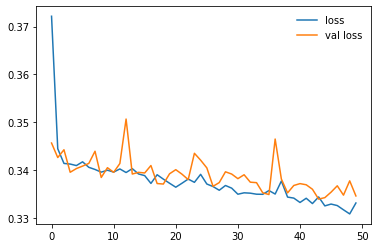

In [14]:
plt.plot(history.history['loss'],label="loss")
plt.plot(history.history['val_loss'],label="val loss")
plt.legend(frameon=False)

In [15]:
preds = pfn.predict(X_val, batch_size=1000)

In [16]:
learned_weights = preds[:,1] / preds[:,0]

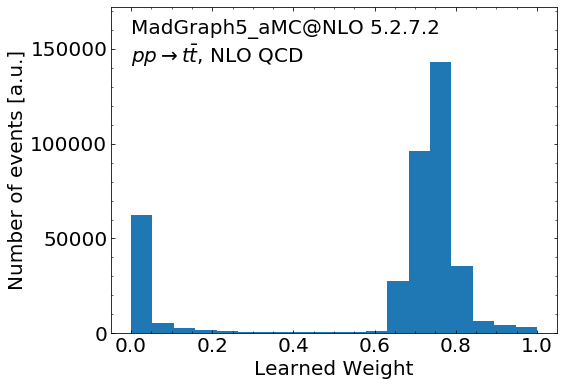

In [17]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()
    
n_hold,_,_=plt.hist(learned_weights,bins=np.linspace(0,1,20))
plt.xlabel(r"Learned Weight",fontsize=20)
plt.ylabel(r"Number of events [a.u.]",fontsize=20)
plt.locator_params(axis='y', nbins=6)

plt.ylim([0,max(n_hold)*1.2])
plt.text(0.,max(n_hold)*1.1,"MadGraph5_aMC@NLO 5.2.7.2",fontsize=20)
plt.text(0.,max(n_hold)*1,r"$pp \rightarrow t\bar{t}$, NLO QCD",fontsize=20)

plt.savefig("PFN_FixedOrder.pdf",bbox_inches='tight')

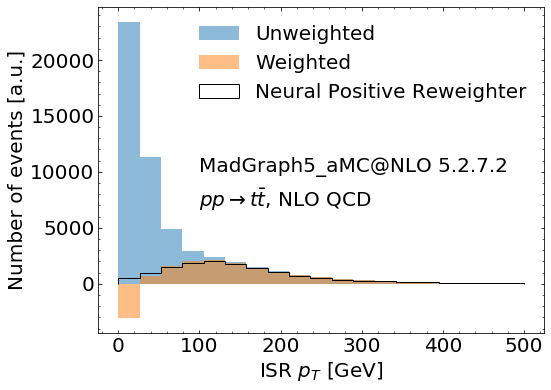

In [18]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

plt.hist(100*X_val[Y_val[:,0]==0][:,2][:,0],alpha=0.5,bins=np.linspace(0.1,500,20),density=False,label="Unweighted")
plt.hist(100*X_val[Y_val[:,0]==0][:,2][:,0],weights=W_val[Y_val[:,0]==0],alpha=0.5,bins=np.linspace(0.1,500,20),density=False,label="Weighted")
plt.hist(100*X_val[Y_val[:,0]==0][:,2][:,0],weights=learned_weights[Y_val[:,0]==0],bins=np.linspace(0.1,500,20),density=False,histtype="step",color="black",label="Neural Positive Reweighter")
#plt.yscale("log")
plt.legend(frameon=False,fontsize=20)
plt.xlabel(r"ISR $p_{T}$ [GeV]",fontsize=20)
plt.ylabel(r"Number of events [a.u.]",fontsize=20)
plt.text(100.,10000,"MadGraph5_aMC@NLO 5.2.7.2",fontsize=20)
plt.text(100.,7000,r"$pp \rightarrow t\bar{t}$, NLO QCD",fontsize=20)
plt.savefig("PFN_FixedOrder_pTISR.pdf",bbox_inches='tight')

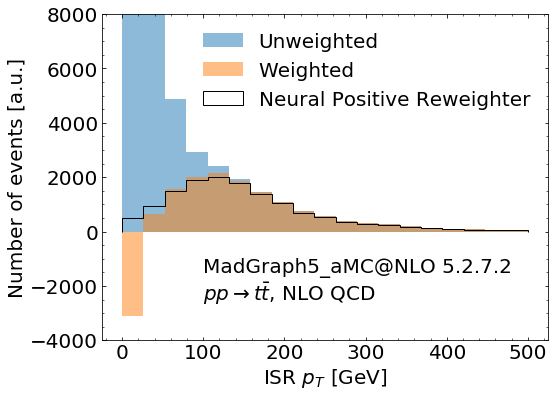

In [19]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

plt.hist(100*X_val[Y_val[:,0]==0][:,2][:,0],alpha=0.5,bins=np.linspace(0.1,500,20),density=False,label="Unweighted")
plt.hist(100*X_val[Y_val[:,0]==0][:,2][:,0],weights=W_val[Y_val[:,0]==0],alpha=0.5,bins=np.linspace(0.1,500,20),density=False,label="Weighted")
plt.hist(100*X_val[Y_val[:,0]==0][:,2][:,0],weights=learned_weights[Y_val[:,0]==0],bins=np.linspace(0.1,500,20),density=False,histtype="step",color="black",label="Neural Positive Reweighter")
#plt.yscale("log")
plt.ylim([-4000,8000])
plt.legend(frameon=False,fontsize=20)
plt.xlabel(r"ISR $p_{T}$ [GeV]",fontsize=20)
plt.ylabel(r"Number of events [a.u.]",fontsize=20)
plt.text(100.,-1500,"MadGraph5_aMC@NLO 5.2.7.2",fontsize=20)
plt.text(100.,-2500,r"$pp \rightarrow t\bar{t}$, NLO QCD",fontsize=20)
plt.savefig("PFN_FixedOrder_pTISR_zoom.pdf",bbox_inches='tight')

In [20]:
#Now, let's try an EFN.

In [21]:
'''
X_noid = X[:,:,:3]

x_vals = np.concatenate([X_noid,X_noid])
y_vals = np.concatenate([np.ones(len(X_noid)),np.zeros(len(X_noid))])
w_vals = np.concatenate([W,np.ones(len(W))])
y_vals = to_categorical(y_vals, num_classes=2)

Z_train_efn, Z_val_efn, P_train_efn, P_val_efn, Y_train_efn, Y_val_efn, W_train_efn, W_val_efn = train_test_split(x_vals[:,:,0], x_vals[:,:,1:], y_vals, w_vals, test_size=0.2)
'''

'\nX_noid = X[:,:,:3]\n\nx_vals = np.concatenate([X_noid,X_noid])\ny_vals = np.concatenate([np.ones(len(X_noid)),np.zeros(len(X_noid))])\nw_vals = np.concatenate([W,np.ones(len(W))])\ny_vals = to_categorical(y_vals, num_classes=2)\n\nZ_train_efn, Z_val_efn, P_train_efn, P_val_efn, Y_train_efn, Y_val_efn, W_train_efn, W_val_efn = train_test_split(x_vals[:,:,0], x_vals[:,:,1:], y_vals, w_vals, test_size=0.2)\n'

In [22]:
#efn = EFN(input_dim=2, Phi_sizes=Phi_sizes, F_sizes=F_sizes)

In [23]:
'''
num_epoch = 300
batch_size = 5000
history_efn = efn.fit([Z_train_efn, P_train_efn], Y_train_efn,
          epochs=num_epoch,
          batch_size=batch_size,
          validation_data=([Z_val_efn, P_val_efn], Y_val_efn, W_val_efn),
          sample_weight=W_train_efn,
          verbose=1)
'''

'\nnum_epoch = 300\nbatch_size = 5000\nhistory_efn = efn.fit([Z_train_efn, P_train_efn], Y_train_efn,\n          epochs=num_epoch,\n          batch_size=batch_size,\n          validation_data=([Z_val_efn, P_val_efn], Y_val_efn, W_val_efn),\n          sample_weight=W_train_efn,\n          verbose=1)\n'

In [24]:
#preds_all_efn = efn.predict([Z_train_efn,P_train_efn], batch_size=1000)
#learned_weights_all_efn = preds_all_efn[:,1] / preds_all_efn[:,0]

In [25]:
'''
plt.hist(100*Z_train_efn[Y_train_efn[:,0]==0][:,2],alpha=0.5,bins=np.linspace(25,500,20),density=False,label="Unweighted")
plt.hist(100*Z_train_efn[Y_train_efn[:,0]==0][:,2],weights=W_train_efn[Y_train_efn[:,0]==0],alpha=0.5,bins=np.linspace(25,500,20),density=False,label="Weighted")
plt.hist(100*Z_train_efn[Y_train_efn[:,0]==0][:,2],weights=learned_weights_all_efn[Y_train_efn[:,0]==0],bins=np.linspace(25,500,20),density=False,histtype="step",color="black",label="NeuralPosReweighter")
#plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel(r"ISR $p_{T}$")
'''

'\nplt.hist(100*Z_train_efn[Y_train_efn[:,0]==0][:,2],alpha=0.5,bins=np.linspace(25,500,20),density=False,label="Unweighted")\nplt.hist(100*Z_train_efn[Y_train_efn[:,0]==0][:,2],weights=W_train_efn[Y_train_efn[:,0]==0],alpha=0.5,bins=np.linspace(25,500,20),density=False,label="Weighted")\nplt.hist(100*Z_train_efn[Y_train_efn[:,0]==0][:,2],weights=learned_weights_all_efn[Y_train_efn[:,0]==0],bins=np.linspace(25,500,20),density=False,histtype="step",color="black",label="NeuralPosReweighter")\n#plt.yscale("log")\nplt.legend(frameon=False)\nplt.xlabel(r"ISR $p_{T}$")\n'

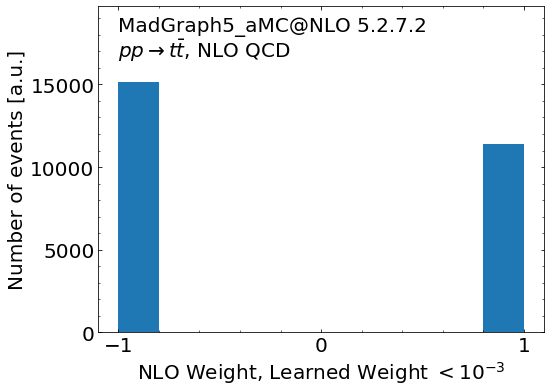

In [26]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()
    
n_hold,_,_=plt.hist(W_val[Y_val[:,1]==1][learned_weights[Y_val[:,1]==1]<0.001])
plt.xlabel(r"NLO Weight, Learned Weight $< 10^{-3}$",fontsize=20)
plt.ylabel(r"Number of events [a.u.]",fontsize=20)
plt.locator_params(axis='y', nbins=6)
plt.locator_params(axis='x', nbins=4)

plt.ylim([0,max(n_hold)*1.3])
plt.text(-1,max(n_hold)*1.2,"MadGraph5_aMC@NLO 5.2.7.2",fontsize=20)
plt.text(-1,max(n_hold)*1.1,r"$pp \rightarrow t\bar{t}$, NLO QCD",fontsize=20)

plt.savefig("WeightsPFN_FixedOrder.pdf",bbox_inches='tight')

In [27]:
#Now, let's try removing these.

In [28]:
preds_train = pfn.predict(X_train, batch_size=1000)
myW_train = preds_train[:,1] / preds_train[:,0]

preds_val = pfn.predict(X_val, batch_size=1000)
myW_val = preds_val[:,1] / preds_val[:,0]

In [29]:
X_train_n = X_train.copy()
Y_train_n = Y_train.copy()
W_train_n = W_train.copy()

X_val_n = X_val.copy()
Y_val_n = Y_val.copy()
W_val_n = W_val.copy()

In [30]:
myweights_n = [myW_val]

for i in range(2):

    X_train_n = X_train_n[myW_train > 1e-3]
    Y_train_n = Y_train_n[myW_train > 1e-3]
    W_train_n = W_train_n[myW_train > 1e-3]

    X_val_n = X_val_n[myW_val > 1e-3]
    Y_val_n = Y_val_n[myW_val > 1e-3]
    W_val_n = W_val_n[myW_val > 1e-3]

    pfn_n = PFN(input_dim=X.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes)
    history_n = pfn_n.fit(X_train_n, Y_train_n,
              epochs=num_epoch,
              batch_size=batch_size,
              validation_data=(X_val_n, Y_val_n, W_val_n),
              sample_weight=W_train_n,
              verbose=1)

    preds_train = pfn_n.predict(X_train_n, batch_size=1000)
    myW_train = preds_train[:,1] / preds_train[:,0]

    preds_val = pfn_n.predict(X_val_n, batch_size=1000)
    myW_val = preds_val[:,1] / preds_val[:,0]

    myweights_n+=[myW_val]
    pass

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None, 4)      0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_8 (Activation)       (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_8[0][0]               
__________________________________________________________________________________________________
activation

Epoch 31/50
1387084/1387084 [==============================] - 3s 2us/step - loss: 0.5641 - acc: 0.5000 - val_loss: 0.5628 - val_acc: 0.5001
Epoch 32/50
1387084/1387084 [==============================] - 3s 2us/step - loss: 0.5637 - acc: 0.5000 - val_loss: 0.5627 - val_acc: 0.4999
Epoch 33/50
1387084/1387084 [==============================] - 3s 2us/step - loss: 0.5637 - acc: 0.5000 - val_loss: 0.5629 - val_acc: 0.4995
Epoch 34/50
1387084/1387084 [==============================] - 3s 2us/step - loss: 0.5636 - acc: 0.5000 - val_loss: 0.5630 - val_acc: 0.5001
Epoch 35/50
1387084/1387084 [==============================] - 3s 2us/step - loss: 0.5638 - acc: 0.4999 - val_loss: 0.5637 - val_acc: 0.4999
Epoch 36/50
1387084/1387084 [==============================] - 3s 2us/step - loss: 0.5638 - acc: 0.5000 - val_loss: 0.5641 - val_acc: 0.4997
Epoch 37/50
1387084/1387084 [==============================] - 3s 2us/step - loss: 0.5630 - acc: 0.4999 - val_loss: 0.5628 - val_acc: 0.4998
Epoch 38/50
1

Epoch 11/50
1381750/1381750 [==============================] - 3s 2us/step - loss: 0.5678 - acc: 0.4998 - val_loss: 0.5649 - val_acc: 0.5000
Epoch 12/50
1381750/1381750 [==============================] - 3s 3us/step - loss: 0.5678 - acc: 0.5001 - val_loss: 0.5653 - val_acc: 0.4998
Epoch 13/50
1381750/1381750 [==============================] - 3s 3us/step - loss: 0.5677 - acc: 0.5000 - val_loss: 0.5649 - val_acc: 0.4998
Epoch 14/50
1381750/1381750 [==============================] - 3s 2us/step - loss: 0.5677 - acc: 0.4999 - val_loss: 0.5651 - val_acc: 0.5000
Epoch 15/50
1381750/1381750 [==============================] - 3s 2us/step - loss: 0.5678 - acc: 0.5000 - val_loss: 0.5651 - val_acc: 0.5000
Epoch 16/50
1381750/1381750 [==============================] - 3s 2us/step - loss: 0.5678 - acc: 0.4999 - val_loss: 0.5651 - val_acc: 0.4999
Epoch 17/50
1381750/1381750 [==============================] - 3s 2us/step - loss: 0.5677 - acc: 0.4999 - val_loss: 0.5653 - val_acc: 0.4996
Epoch 18/50
1

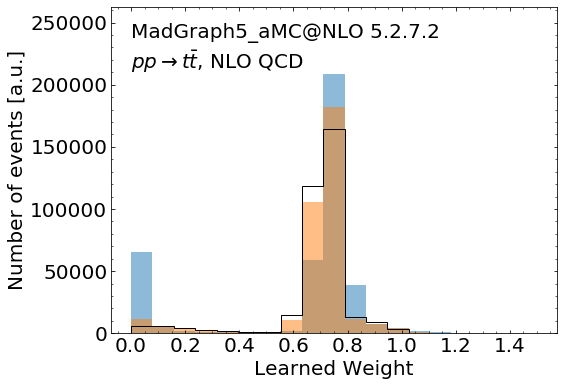

In [31]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

for i in range(len(myweights_n)-1):
    plt.hist(myweights_n[i],bins=np.linspace(0,1.5,20),alpha=0.5)
    pass
n_hold,_,_=plt.hist(myweights_n[-1],bins=np.linspace(0,1.5,20),color="black",histtype="step")

plt.xlabel(r"Learned Weight",fontsize=20)
plt.ylabel(r"Number of events [a.u.]",fontsize=20)
plt.locator_params(axis='y', nbins=6)

plt.ylim([0,max(n_hold)*1.6])
plt.text(0.,max(n_hold)*1.45,"MadGraph5_aMC@NLO 5.2.7.2",fontsize=20)
plt.text(0.,max(n_hold)*1.3,r"$pp \rightarrow t\bar{t}$, NLO QCD",fontsize=20)

plt.savefig("PFN_FixedOrder_weights_purified.pdf",bbox_inches='tight')

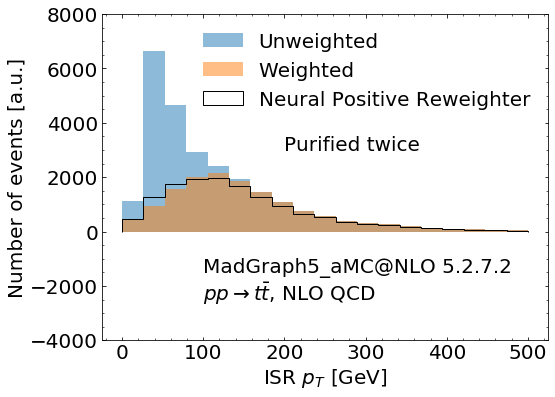

In [32]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

plt.hist(100*X_val_n[Y_val_n[:,0]==0][:,2][:,0],alpha=0.5,bins=np.linspace(0.1,500,20),density=False,label="Unweighted")
plt.hist(100*X_val_n[Y_val_n[:,0]==0][:,2][:,0],weights=W_val_n[Y_val_n[:,0]==0],alpha=0.5,bins=np.linspace(0.1,500,20),density=False,label="Weighted")
plt.hist(100*X_val_n[Y_val_n[:,0]==0][:,2][:,0],weights=myweights_n[-1][Y_val_n[:,0]==0],bins=np.linspace(0.1,500,20),density=False,histtype="step",color="black",label="Neural Positive Reweighter")
#plt.yscale("log")
plt.ylim([-4000,8000])
plt.legend(frameon=False,fontsize=20)
plt.xlabel(r"ISR $p_{T}$ [GeV]",fontsize=20)
plt.ylabel(r"Number of events [a.u.]",fontsize=20)
plt.text(200.,3000,"Purified twice",fontsize=20)
plt.text(100.,-1500,"MadGraph5_aMC@NLO 5.2.7.2",fontsize=20)
plt.text(100.,-2500,r"$pp \rightarrow t\bar{t}$, NLO QCD",fontsize=20)
plt.savefig("PFN_FixedOrder_pTISR_zoom_purified.pdf",bbox_inches='tight')

In [33]:
#Learn directly this distribution, after pT cut.

In [34]:
hold = X[:,2][:,0]*100
holdW = W[hold > 25]
hold = hold[hold > 25]

In [99]:
xx_vals = np.concatenate([hold/100.,hold/100.])
yy_vals = np.concatenate([np.ones(len(hold)),np.zeros(len(hold))])
ww_vals = np.concatenate([holdW,np.ones(len(hold))])
XX_train, XX_val, YY_train, YY_val, WW_train, WW_val = train_test_split(xx_vals, yy_vals, ww_vals, test_size=0.5)

In [100]:
model = Sequential()
model.add(Dense(128, input_dim=1, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [101]:
myhistory_1D = model.fit(XX_train, YY_train, sample_weight=WW_train,epochs=50, validation_data=(XX_val, YY_val, WW_val), batch_size=256,verbose=1)

Train on 151229 samples, validate on 151229 samples
Epoch 1/50
151229/151229 [==============================] - 5s 33us/step - loss: 0.3942 - acc: 0.4994 - val_loss: 0.3812 - val_acc: 0.4988
Epoch 2/50
151229/151229 [==============================] - 4s 29us/step - loss: 0.3839 - acc: 0.5008 - val_loss: 0.3795 - val_acc: 0.4997
Epoch 3/50
151229/151229 [==============================] - 4s 29us/step - loss: 0.3839 - acc: 0.5001 - val_loss: 0.3805 - val_acc: 0.4993
Epoch 4/50
151229/151229 [==============================] - 4s 29us/step - loss: 0.3835 - acc: 0.5008 - val_loss: 0.3829 - val_acc: 0.4994
Epoch 5/50
151229/151229 [==============================] - 4s 29us/step - loss: 0.3839 - acc: 0.5008 - val_loss: 0.3786 - val_acc: 0.4996
Epoch 6/50
151229/151229 [==============================] - 4s 29us/step - loss: 0.3835 - acc: 0.4997 - val_loss: 0.3789 - val_acc: 0.4997
Epoch 7/50
151229/151229 [==============================] - 4s 29us/step - loss: 0.3829 - acc: 0.5005 - val_loss: 

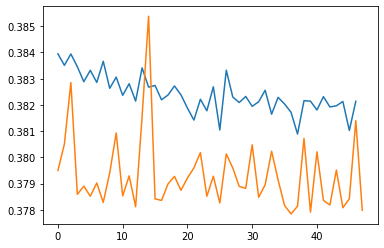

In [102]:
plt.plot(myhistory_1D.history['loss'][2:-1])
plt.plot(myhistory_1D.history['val_loss'][1:-1])

In [103]:
predicted_w = model.predict(XX_val[YY_val==0])

In [104]:
myw = predicted_w / (1.-predicted_w)

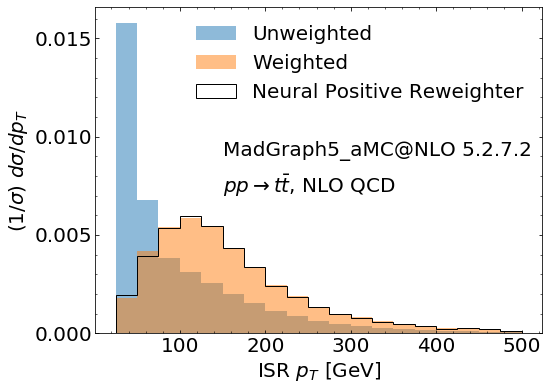

In [105]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()
    
plt.hist(100*XX_val[YY_val==1],alpha=0.5,bins=np.linspace(25,500,20),density=True,label="Unweighted")
plt.hist(100*XX_val[YY_val==1],weights=WW_val[YY_val==1],alpha=0.5,bins=np.linspace(25,500,20),density=True,label="Weighted")
plt.hist(100*XX_val[YY_val==0],weights=myw,bins=np.linspace(25,500,20),density=True,histtype="step",color="black",label="Neural Positive Reweighter")
#plt.yscale("log")
plt.legend(frameon=False,fontsize=20)
plt.xlabel(r"ISR $p_{T}$ [GeV]",fontsize=20)
plt.ylabel(r"$(1/\sigma)$ $d\sigma/dp_{T}$",fontsize=20)
plt.locator_params(axis='y', nbins=6)

plt.text(150,0.009,"MadGraph5_aMC@NLO 5.2.7.2",fontsize=20)
plt.text(150,0.0072,r"$pp \rightarrow t\bar{t}$, NLO QCD",fontsize=20)
plt.savefig("isrpt.pdf",bbox_inches='tight')

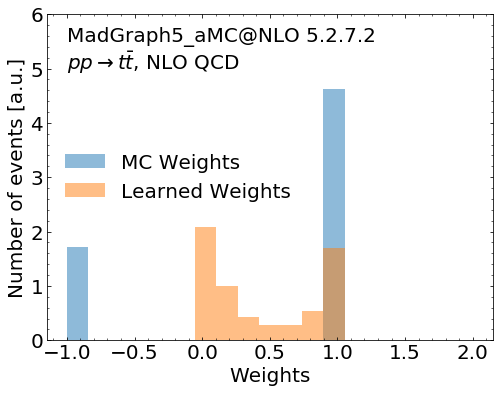

In [106]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()
    
plt.hist(WW_val[YY_val==1],alpha=0.5,bins=np.linspace(-1,2,20),density=True,label="MC Weights")
plt.hist(myw,alpha=0.5,bins=np.linspace(-1,2,20),density=True,label="Learned Weights")
plt.legend(frameon=False,fontsize=20,loc="center left")
plt.xlabel(r"Weights",fontsize=20)
plt.ylabel(r"Number of events [a.u.]",fontsize=20)
plt.locator_params(axis='y', nbins=6)

plt.ylim([0,6])
plt.text(-1,5.5,"MadGraph5_aMC@NLO 5.2.7.2",fontsize=20)
plt.text(-1,5.,r"$pp \rightarrow t\bar{t}$, NLO QCD",fontsize=20)
plt.savefig("wisrpt.pdf",bbox_inches='tight')

## Matched example

In [42]:
myweights_full=[]
X_full = []
mycounter = 0
for e in open('/data0/bpnachman/NeuralPosReweight/TruthttbarQCD_5.txt'):
    myweights_full+=[float(e.split()[0])]
    nparts = int(len(e.split()[1:])/6)
    myevent = []
    for i in range(nparts):
        pT = float(e.split()[1:][6*i+1])
        eta = float(e.split()[1:][6*i+2])
        phi = float(e.split()[1:][6*i+3])
        m = float(e.split()[1:][6*i+4])
        pid = int(e.split()[1:][6*i+5])
        myevent+=[[pT,eta,phi,m,pid]]
        #print(". ",i,pT,eta,phi,m,pid)
    myevent = np.array(myevent)
    X_full+=[myevent]
    #print(nparts)
    #print(e.split()[1:])
    #if (mycounter > 1):
    #    break
    mycounter+=1
    if (mycounter%100000==0):
        print(mycounter)

100000
200000
300000
400000
500000


In [43]:
X_full_copy = X_full.copy()

In [44]:
X_full_copy_fixed = []
for i in range(len(X_full_copy)):
    myoutput=np.zeros([15,5])
    for j in range(min(len(X_full_copy[i]),15)):
        myoutput[j,:] = X_full_copy[i][j][:]
        myoutput[j,4] /= 20.
        myoutput[j,1:3] /= np.pi
        myoutput[j,0] /= 100.
        pass
    X_full_copy_fixed+=[myoutput]
np.shape(X_full_copy_fixed)

(500000, 15, 5)

In [45]:
Wf = myweights_full.copy()
Wf /= np.mean(np.abs(Wf))
Xf = X_full_copy_fixed.copy()
Xf = np.array(Xf)

In [46]:
xf_vals = np.concatenate([Xf,Xf])
yf_vals = np.concatenate([np.ones(len(Xf)),np.zeros(len(Xf))])
wf_vals = np.concatenate([Wf,np.ones(len(Wf))])
yf_vals = to_categorical(yf_vals, num_classes=2)

In [47]:
Xf_train, Xf_val, Yf_train, Yf_val, Wf_train, Wf_val = train_test_split(xf_vals, yf_vals, wf_vals, test_size=0.2)

In [48]:
Phi_sizes, F_sizes = (100, 100, 128), (100, 100, 100)
pfnf = PFN(input_dim=Xf.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None, 5)      0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    600         input[0][0]                      
__________________________________________________________________________________________________
activation_22 (Activation)      (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_22[0][0]              
__________________________________________________________________________________________________
activation

In [49]:
num_epoch = 50
batch_size = 500 #was 5000
historyf = pfnf.fit(Xf_train, Yf_train,
          epochs=num_epoch,
          batch_size=batch_size,
          validation_data=(Xf_val, Yf_val, Wf_val),
          sample_weight=Wf_train,
          verbose=1)

Train on 800000 samples, validate on 200000 samples
Epoch 1/50
800000/800000 [==============================] - 14s 17us/step - loss: 0.5144 - acc: 0.5004 - val_loss: 0.4917 - val_acc: 0.4977
Epoch 2/50
800000/800000 [==============================] - 13s 17us/step - loss: 0.4920 - acc: 0.5006 - val_loss: 0.4948 - val_acc: 0.4974
Epoch 3/50
800000/800000 [==============================] - 13s 17us/step - loss: 0.4899 - acc: 0.5006 - val_loss: 0.4880 - val_acc: 0.4977
Epoch 4/50
800000/800000 [==============================] - 13s 16us/step - loss: 0.4892 - acc: 0.5006 - val_loss: 0.4873 - val_acc: 0.4977
Epoch 5/50
800000/800000 [==============================] - 13s 17us/step - loss: 0.4894 - acc: 0.5006 - val_loss: 0.4876 - val_acc: 0.4977
Epoch 6/50
800000/800000 [==============================] - 13s 17us/step - loss: 0.4889 - acc: 0.5006 - val_loss: 0.4875 - val_acc: 0.4977
Epoch 7/50
800000/800000 [==============================] - 13s 17us/step - loss: 0.4886 - acc: 0.5006 - val

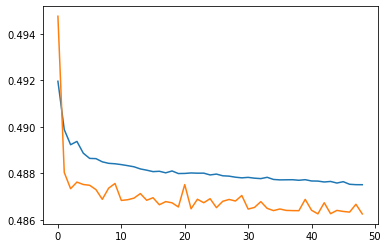

In [50]:
plt.plot(historyf.history['loss'][1:])
plt.plot(historyf.history['val_loss'][1:])

In [51]:
predsf = pfnf.predict(Xf_val, batch_size=1000)
learned_weightsf = predsf[:,1] / predsf[:,0]

In [52]:
nnonbjetsf = []
pTsISRf = []
for i in range(len(Xf_val)):
    nnonbjet = 0
    pTISR = 0.
    for j in range(len(Xf_val[i])):
        if (Xf_val[i][j][0] == 0):
            continue
        if (Xf_val[i][j][4]*20 < 10):
            if (Xf_val[i][j][4]*20 < 1):
                nnonbjet+=1
                if (Xf_val[i][j][0]*100 > pTISR):
                    pTISR = Xf_val[i][j][0]*100
                    pass
                pass
            pass
        pass
    nnonbjetsf+=[nnonbjet]
    pTsISRf+=[pTISR]
    pass
nnonbjetsf = np.array(nnonbjetsf)
pTsISRf = np.array(pTsISRf)

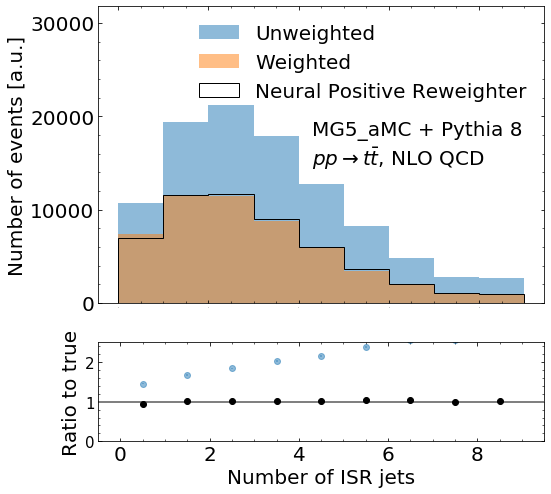

In [53]:
fig = plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(2, 1, height_ratios=[3,1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

plt.xlabel(r"",fontsize=20)
plt.ylabel(r"Number of events [a.u.]",fontsize=20)
plt.locator_params(axis='y', nbins=6)

myn,bmjj,_=plt.hist(nnonbjetsf[Yf_val[:,0]==0],bins=range(10),alpha=0.5,density=False,label="Unweighted")
myn2,_,_=plt.hist(nnonbjetsf[Yf_val[:,0]==0],bins=range(10),weights=Wf_val[Yf_val[:,0]==0],alpha=0.5,density=False,label="Weighted")
myn3,_,_=plt.hist(nnonbjetsf[Yf_val[:,0]==0],bins=range(10),weights=learned_weightsf[Yf_val[:,0]==0],histtype="step",density=False,label="Neural Positive Reweighter",color="black")
plt.legend(frameon=False,fontsize=20)
plt.xticks(fontsize=0)

plt.ylim([0,max(myn)*1.5])
plt.text(4.3,max(myn)*0.85,"MG5_aMC + Pythia 8",fontsize=20)
plt.text(4.3,max(myn)*0.7,r"$pp \rightarrow t\bar{t}$, NLO QCD",fontsize=20)

ax1 = plt.subplot(gs[1])
ax1.yaxis.set_ticks_position('both')
ax1.xaxis.set_ticks_position('both')
ax1.tick_params(direction="in",which="both")
ax1.minorticks_on()
plt.locator_params(axis='x', nbins=6)
plt.xlabel(r"Number of ISR jets",fontsize=20)
plt.ylabel("Ratio to true",fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=15)
plt.axhline(y=1,linewidth=2, color='gray')   
plt.errorbar(0.5*(bmjj[1:]+bmjj[:-1]),myn3/myn2,yerr=(myn3+myn2)**0.5/myn2,color='black',fmt='o')
plt.errorbar(0.5*(bmjj[1:]+bmjj[:-1]),myn/myn2,yerr=(myn+myn2)**0.5/myn2,color='#1f77b4',fmt='o',alpha=0.5)
plt.ylim(0.,2.5)
plt.xlim(-0.5,9.5)

plt.savefig("ISRnjets_full.pdf",bbox_inches='tight')

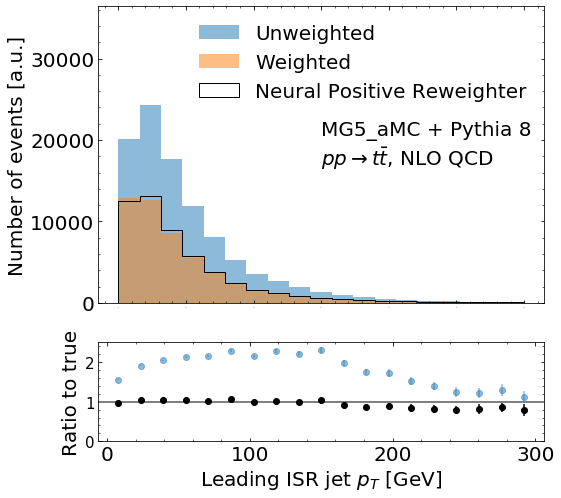

In [54]:
fig = plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(2, 1, height_ratios=[3,1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

plt.xlabel(r"",fontsize=20)
plt.ylabel(r"Number of events [a.u.]",fontsize=20)
plt.locator_params(axis='y', nbins=6)

myn,bmjj,_=plt.hist(pTsISRf[Yf_val[:,0]==0],bins=np.linspace(0,300,20),alpha=0.5,density=False,label="Unweighted")
myn2,_,_=plt.hist(pTsISRf[Yf_val[:,0]==0],bins=np.linspace(0,300,20),weights=Wf_val[Yf_val[:,0]==0],alpha=0.5,density=False,label="Weighted")
myn3,_,_=plt.hist(pTsISRf[Yf_val[:,0]==0],bins=np.linspace(0,300,20),weights=learned_weightsf[Yf_val[:,0]==0],histtype="step",density=False,label="Neural Positive Reweighter",color="black")
plt.legend(frameon=False,fontsize=20)
plt.xticks(fontsize=0)

plt.ylim([0,max(myn)*1.5])
plt.text(150,max(myn)*0.85,"MG5_aMC + Pythia 8",fontsize=20)
plt.text(150,max(myn)*0.7,r"$pp \rightarrow t\bar{t}$, NLO QCD",fontsize=20)

ax1 = plt.subplot(gs[1])
ax1.yaxis.set_ticks_position('both')
ax1.xaxis.set_ticks_position('both')
ax1.tick_params(direction="in",which="both")
ax1.minorticks_on()
plt.locator_params(axis='x', nbins=6)
plt.xlabel(r"Leading ISR jet $p_T$ [GeV]",fontsize=20)
plt.ylabel("Ratio to true",fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=15)
plt.axhline(y=1,linewidth=2, color='gray')   
plt.errorbar(0.5*(bmjj[1:]+bmjj[:-1]),myn3/myn2,yerr=(myn3+myn2)**0.5/myn2,color='black',fmt='o')
plt.errorbar(0.5*(bmjj[1:]+bmjj[:-1]),myn/myn2,yerr=(myn+myn2)**0.5/myn2,color='#1f77b4',fmt='o',alpha=0.5)
plt.ylim(0.,2.5)
#plt.xlim(-0.5,9.5)

plt.savefig("ISRpT_full.pdf",bbox_inches='tight')

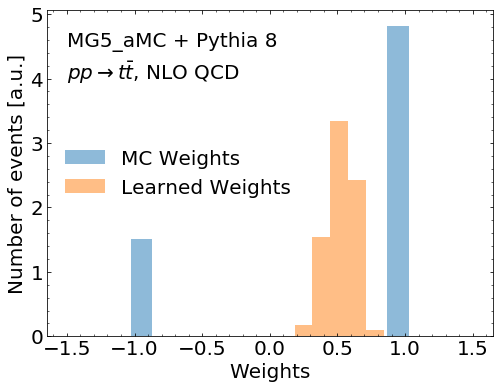

In [55]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()
    
plt.hist(Wf_val[Yf_val[:,0]==0],alpha=0.5,bins=np.linspace(-1.5,1.5,20),density=True,label="MC Weights")
plt.hist(learned_weightsf[Yf_val[:,0]==0],alpha=0.5,bins=np.linspace(-1,1.5,20),density=True,label="Learned Weights")
plt.legend(frameon=False,fontsize=20,loc="center left")
plt.xlabel(r"Weights",fontsize=20)
plt.ylabel(r"Number of events [a.u.]",fontsize=20)
plt.locator_params(axis='y', nbins=6)

#plt.ylim([0,6])
plt.text(-1.5,4.5,"MG5_aMC + Pythia 8",fontsize=20)
plt.text(-1.5,4,r"$pp \rightarrow t\bar{t}$, NLO QCD",fontsize=20)
plt.savefig("wisrpt_full.pdf",bbox_inches='tight')

## Now for reducing the stats.

In [109]:
keepprobs = learned_weightsf[Yf_val[:,0]==0]**2
for i in range(len(keepprobs)):
    if (keepprobs[i] > 1.):
        keepprobs[i]=1.
        pass
    pass
keep = np.random.binomial(1,keepprobs)
initweights = learned_weightsf[Yf_val[:,0]==0]
initxvals1 = pTsISRf[Yf_val[:,0]==0]
initxvals2 = nnonbjetsf[Yf_val[:,0]==0]
neweights = []
newxvals1 = []
newxvals2 = []
for i in range(len(keep)):
    if (keep[i]==1):
        neweights+=[1./(0.00001+initweights[i])]
        newxvals1+=[initxvals1[i]]
        newxvals2+=[initxvals2[i]]
    pass

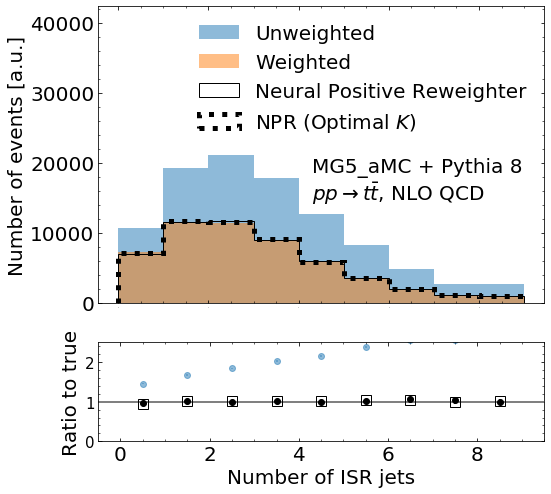

In [129]:
fig = plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(2, 1, height_ratios=[3,1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

plt.xlabel(r"",fontsize=20)
plt.ylabel(r"Number of events [a.u.]",fontsize=20)
plt.locator_params(axis='y', nbins=6)

myn,bmjj,_=plt.hist(nnonbjetsf[Yf_val[:,0]==0],bins=range(10),alpha=0.5,density=False,label="Unweighted")
myn2,_,_=plt.hist(nnonbjetsf[Yf_val[:,0]==0],bins=range(10),weights=Wf_val[Yf_val[:,0]==0],alpha=0.5,density=False,label="Weighted")
myn3,_,_=plt.hist(nnonbjetsf[Yf_val[:,0]==0],bins=range(10),weights=learned_weightsf[Yf_val[:,0]==0],histtype="step",density=False,label="Neural Positive Reweighter",color="black")
myn4,_,_=plt.hist(newxvals2,bins=range(10),weights=neweights,histtype="step",density=False,label=r"NPR (Optimal $K$)",color="black",ls=":",linewidth=5)
plt.legend(frameon=False,fontsize=20)
plt.xticks(fontsize=0)

plt.ylim([0,max(myn)*2.])
plt.text(4.3,max(myn)*0.88,"MG5_aMC + Pythia 8",fontsize=20)
plt.text(4.3,max(myn)*0.7,r"$pp \rightarrow t\bar{t}$, NLO QCD",fontsize=20)

ax1 = plt.subplot(gs[1])
ax1.yaxis.set_ticks_position('both')
ax1.xaxis.set_ticks_position('both')
ax1.tick_params(direction="in",which="both")
ax1.minorticks_on()
plt.locator_params(axis='x', nbins=6)
plt.xlabel(r"Number of ISR jets",fontsize=20)
plt.ylabel("Ratio to true",fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=15)
plt.axhline(y=1,linewidth=2, color='gray')   
plt.errorbar(0.5*(bmjj[1:]+bmjj[:-1]),myn3/myn2,yerr=(myn3+myn2)**0.5/myn2,color='black',fmt='s',fillstyle="none",markersize=10)
plt.errorbar(0.5*(bmjj[1:]+bmjj[:-1]),myn4/myn2,yerr=(myn4+myn2)**0.5/myn2,color='black',fmt="o")
plt.errorbar(0.5*(bmjj[1:]+bmjj[:-1]),myn/myn2,yerr=(myn+myn2)**0.5/myn2,color='#1f77b4',fmt='o',alpha=0.5)
plt.ylim(0.,2.5)
plt.xlim(-0.5,9.5)

plt.savefig("ISRnjets_full_withk.pdf",bbox_inches='tight')

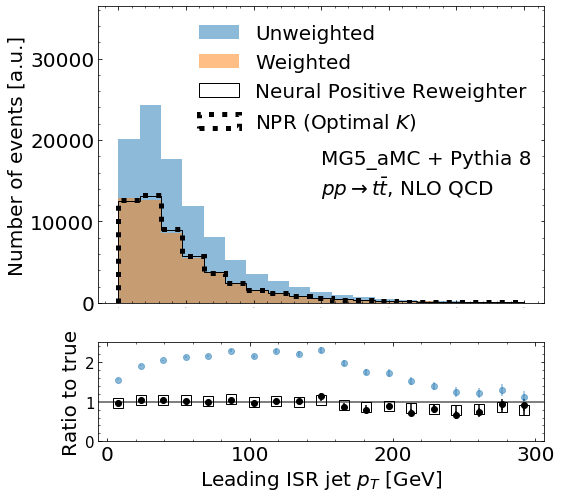

In [142]:
fig = plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(2, 1, height_ratios=[3,1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

plt.xlabel(r"",fontsize=20)
plt.ylabel(r"Number of events [a.u.]",fontsize=20)
plt.locator_params(axis='y', nbins=6)

myn,bmjj,_=plt.hist(pTsISRf[Yf_val[:,0]==0],bins=np.linspace(0,300,20),alpha=0.5,density=False,label="Unweighted")
myn2,_,_=plt.hist(pTsISRf[Yf_val[:,0]==0],bins=np.linspace(0,300,20),weights=Wf_val[Yf_val[:,0]==0],alpha=0.5,density=False,label="Weighted")
myn3,_,_=plt.hist(pTsISRf[Yf_val[:,0]==0],bins=np.linspace(0,300,20),weights=learned_weightsf[Yf_val[:,0]==0],histtype="step",density=False,label="Neural Positive Reweighter",color="black")
myn4,_,_=plt.hist(newxvals1,bins=np.linspace(0,300,20),weights=neweights,histtype="step",density=False,label=r"NPR (Optimal $K$)",color="black",ls=":",linewidth=5)
plt.legend(frameon=False,fontsize=20)
plt.xticks(fontsize=0)

plt.ylim([0,max(myn)*1.5])
plt.text(150,max(myn)*0.7,"MG5_aMC + Pythia 8",fontsize=20)
plt.text(150,max(myn)*0.55,r"$pp \rightarrow t\bar{t}$, NLO QCD",fontsize=20)

ax1 = plt.subplot(gs[1])
ax1.yaxis.set_ticks_position('both')
ax1.xaxis.set_ticks_position('both')
ax1.tick_params(direction="in",which="both")
ax1.minorticks_on()
plt.locator_params(axis='x', nbins=6)
plt.xlabel(r"Leading ISR jet $p_T$ [GeV]",fontsize=20)
plt.ylabel("Ratio to true",fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=15)
plt.axhline(y=1,linewidth=2, color='gray')   
plt.errorbar(0.5*(bmjj[1:]+bmjj[:-1]),myn3/myn2,yerr=(myn3+myn2)**0.5/myn2,color='black',fmt='s',fillstyle="none",markersize=10)
plt.errorbar(0.5*(bmjj[1:]+bmjj[:-1]),myn4/myn2,yerr=(myn4+myn2)**0.5/myn2,color='black',fmt="o")
plt.errorbar(0.5*(bmjj[1:]+bmjj[:-1]),myn/myn2,yerr=(myn+myn2)**0.5/myn2,color='#1f77b4',fmt='o',alpha=0.5)
plt.ylim(0.,2.5)
#plt.xlim(-0.5,9.5)

plt.savefig("ISRpT_full_withk.pdf",bbox_inches='tight')

In [146]:
neweights = np.array(neweights)

In [143]:
Bins_val = np.array([np.digitize(x,np.linspace(0,300,20)) for x in pTsISRf[Yf_val[:,0]==0]])
Bins_newval = np.array([np.digitize(x,np.linspace(0,300,20)) for x in newxvals1])

In [144]:
Bins2_val = np.array([np.digitize(x,range(10)) for x in nnonbjetsf[Yf_val[:,0]==0]])
Bins2_newval = np.array([np.digitize(x,range(10)) for x in newxvals2])

In [147]:
W2_original = [sum(Wf_val[Yf_val[:,0]==0][Bins_val==i]**2) for i in range(20)]
W2_new = [sum(learned_weightsf[Yf_val[:,0]==0][Bins_val==i]**2) for i in range(20)]
W2_sampled = [sum(neweights[Bins_newval==i]**2) for i in range(20)]

L2_original = [len(Wf_val[Yf_val[:,0]==0][Bins_val==i]**2) for i in range(20)]
L2_new = [len(learned_weightsf[Yf_val[:,0]==0][Bins_val==i]**2) for i in range(20)]
L2_sampled = [len(neweights[Bins_newval==i]**2) for i in range(20)]

In [148]:
W2_original2 = [sum(Wf_val[Yf_val[:,0]==0][Bins2_val==i]**2) for i in range(10)]
W2_new2 = [sum(learned_weightsf[Yf_val[:,0]==0][Bins2_val==i]**2) for i in range(10)]
W2_sampled2 = [sum(neweights[Bins2_newval==i]**2) for i in range(10)]

L2_original2 = [len(Wf_val[Yf_val[:,0]==0][Bins2_val==i]**2) for i in range(10)]
L2_new2 = [len(learned_weightsf[Yf_val[:,0]==0][Bins2_val==i]**2) for i in range(10)]
L2_sampled2 = [len(neweights[Bins2_newval==i]**2) for i in range(10)]

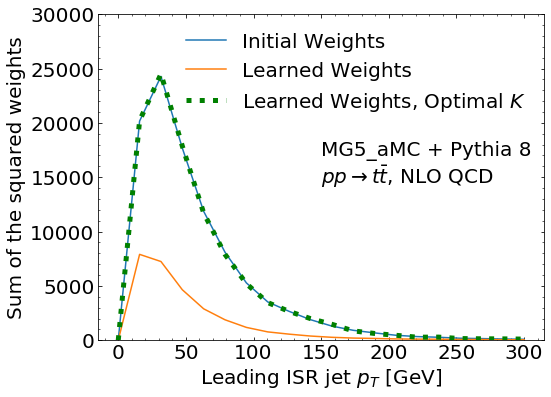

In [155]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

plt.plot(np.linspace(0,300,20),W2_original,label="Initial Weights")
plt.plot(np.linspace(0,300,20),W2_new,label="Learned Weights")
plt.plot(np.linspace(0,300,20),W2_sampled,label=r"Learned Weights, Optimal $K$",ls=":",linewidth=5,color="green")
plt.legend(frameon=False,fontsize=20,loc="upper right")

plt.ylim([0,30000])
plt.ylabel("Sum of the squared weights",fontsize=20)
plt.xlabel(r"Leading ISR jet $p_T$ [GeV]",fontsize=20)
plt.locator_params(axis='y', nbins=6)

plt.text(150,17000,"MG5_aMC + Pythia 8",fontsize=20)
plt.text(150,14500,r"$pp \rightarrow t\bar{t}$, NLO QCD",fontsize=20)

plt.savefig("ISRpT_full_withk_sumw2.pdf",bbox_inches='tight')

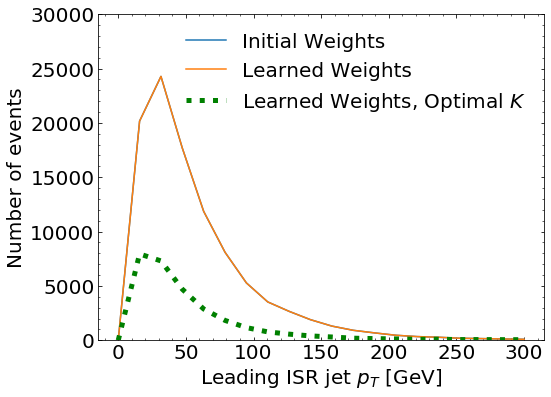

In [156]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

plt.plot(np.linspace(0,300,20),L2_original,label="Initial Weights")
plt.plot(np.linspace(0,300,20),L2_new,label="Learned Weights")
plt.plot(np.linspace(0,300,20),L2_sampled,label=r"Learned Weights, Optimal $K$",ls=":",linewidth=5,color="green")
plt.legend(frameon=False,fontsize=20,loc="upper right")

plt.ylim([0,30000])
plt.ylabel("Number of events",fontsize=20)
plt.xlabel(r"Leading ISR jet $p_T$ [GeV]",fontsize=20)
plt.locator_params(axis='y', nbins=6)
plt.savefig("ISRpT_full_withk_Number.pdf",bbox_inches='tight')

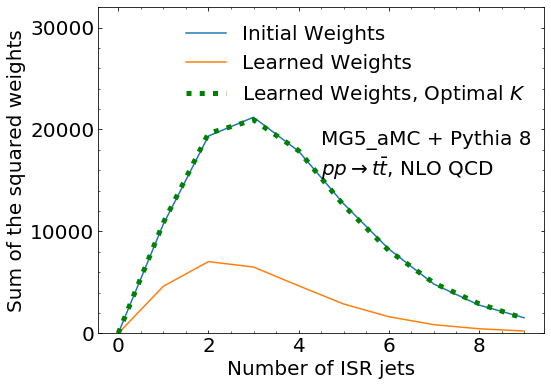

In [164]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

plt.plot(range(10),W2_original2,label="Initial Weights")
plt.plot(range(10),W2_new2,label="Learned Weights")
plt.plot(range(10),W2_sampled2,label=r"Learned Weights, Optimal $K$",ls=":",linewidth=5,color="green")
plt.legend(frameon=False,fontsize=20,loc="upper right")

plt.ylim([0,32000])
plt.ylabel("Sum of the squared weights",fontsize=20)
plt.xlabel(r"Number of ISR jets",fontsize=20)
plt.locator_params(axis='y', nbins=6)

plt.text(4.5,18500,"MG5_aMC + Pythia 8",fontsize=20)
plt.text(4.5,15500,r"$pp \rightarrow t\bar{t}$, NLO QCD",fontsize=20)

plt.savefig("ISRnjets_full_withk_sumw2.pdf",bbox_inches='tight')